In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('acetylcholinesterase_03_bioactivity_data_curated.csv')
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active


In [3]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [4]:
smiles = []

for i in df.canonical_smiles.tolist():
    cpd = str(i).split('.')
    cpd_longest = max(cpd,key=len)
    smiles.append(cpd_longest)
    
smiles = pd.Series(smiles, name='canonical_smiles')

In [5]:
df_clean_smiles = pd.concat([df_no_smiles, smiles], axis=1)
df_clean_smiles.head()

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C


## Calculate Lipsinki descriptor

### Import Libraries

In [8]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### Calculate descriptors

In [11]:
def lipinski(smiles, verbose=False):
    
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)
        
    baseData = np.arange(1,1)
    i = 0
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [12]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski.head()

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.8032,0.0,6.0
1,376.913,4.5546,0.0,5.0
2,426.851,5.3574,0.0,5.0
3,404.845,4.7069,0.0,5.0
4,346.334,3.0953,0.0,6.0


In [13]:
df_combined = pd.concat([df,df_lipinski], axis=1)
df_combined.head()

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active,312.325,2.8032,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active,376.913,4.5546,0.0,5.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive,426.851,5.3574,0.0,5.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active,404.845,4.7069,0.0,5.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active,346.334,3.0953,0.0,6.0


### Convert IC50 to pIC50

In [14]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [15]:
df_combined.standard_value.describe()

count    5.023000e+03
mean     3.001259e+12
std      1.150104e+14
min      5.000000e-06
25%      1.206150e+02
50%      2.010000e+03
75%      1.540000e+04
max      5.888437e+15
Name: standard_value, dtype: float64

In [16]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [17]:
df_norm = norm_value(df_combined)
df_norm.head()

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,800.0


In [18]:
df_norm.standard_value_norm.describe()

count    5.023000e+03
mean     3.072049e+05
std      4.562366e+06
min      5.000000e-06
25%      1.206150e+02
50%      2.010000e+03
75%      1.540000e+04
max      1.000000e+08
Name: standard_value_norm, dtype: float64

In [19]:
df_final = pIC50(df_norm)
df_final.head()

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910


In [20]:
df_final.pIC50.describe()

count    5023.000000
mean        5.865702
std         1.613073
min         1.000000
25%         4.812479
50%         5.696804
75%         6.918601
max        14.301030
Name: pIC50, dtype: float64

In [21]:
df_final.to_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')

### Removing 'intermediate' class

In [22]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class.head()

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910


In [23]:
df_2class.to_csv('acetylcholinesterase_05_bioactivity_data_2class_pIC50.csv')

## EDA

### Import library

In [26]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### Frequency plot of the 2 bioactivity classes

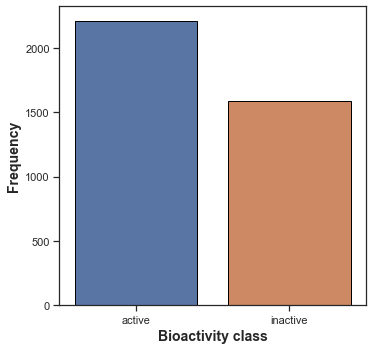

In [27]:
plt.figure(figsize=(5.5,5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### Scatter plot of MW versus LogP

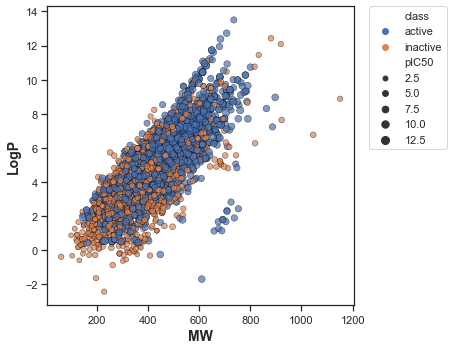

In [28]:
plt.figure(figsize=(5.5,5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)
plt.savefig('plot_Mw_vs_LogP.pdf')

### Box plots

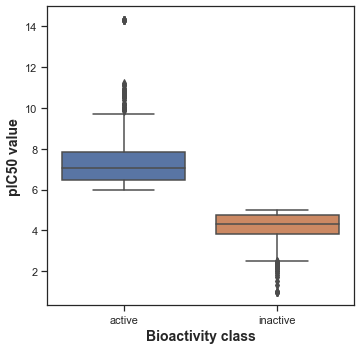

In [29]:
plt.figure(figsize=(5.5,5.5))

sns.boxplot(x='class',y='pIC50', data=df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [30]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [31]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,0.0,0.05,Different distribution (reject H0)


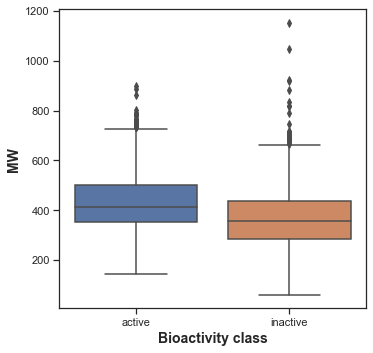

In [32]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [33]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1201698.0,4.557230e-62,0.05,Different distribution (reject H0)


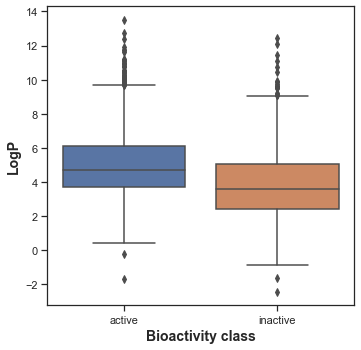

In [34]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [35]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1170622.5,5.383888e-69,0.05,Different distribution (reject H0)


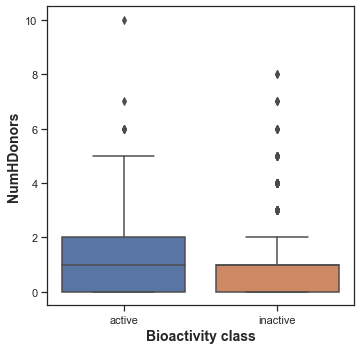

In [36]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [37]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1515454.5,2.629091e-14,0.05,Different distribution (reject H0)


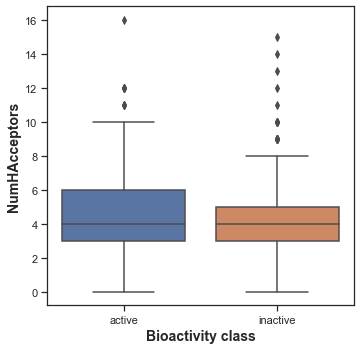

In [38]:

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [39]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1630624.5,0.000079,0.05,Different distribution (reject H0)
